In [1]:
!pip install yfinance

In [2]:
import numpy as np
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from math import floor
from termcolor import colored as cl

In [3]:
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (20,10)

In [4]:
def get_historical_data(symbol, start_date, end_date=None):
    """
    Fetch historical stock data using yfinance

    Parameters:
    symbol (str): Stock ticker symbol
    start_date (str): Start date for data retrieval (YYYY-MM-DD)
    end_date (str, optional): End date for data retrieval. Defaults to None (current date).

    Returns:
    pandas.DataFrame: DataFrame with stock data
    """
    # Fetch data using yfinance with explicit auto_adjust
    df = yf.download(symbol, start=start_date, end=end_date, auto_adjust=True)

    # Ensure we're using closing prices
    df = df['Close']


    # Convert to DataFrame with single 'Close' column
    df.columns = ['close']  # Rename column

    return df

In [5]:
df=get_historical_data('BTC-USD','2015-01-01','2024-01-01')

[*********************100%***********************]  1 of 1 completed


In [6]:
df

,close
Date,
2015-01-01,314.248993
2015-01-02,315.032013
2015-01-03,281.082001
2015-01-04,264.195007
2015-01-05,274.473999
...,...
2023-12-27,43442.855469
2023-12-28,42627.855469
2023-12-29,42099.402344


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3287 entries, 2015-01-01 to 2023-12-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   close   3287 non-null   float64
dtypes: float64(1)
memory usage: 51.4 KB


In [8]:
def sma(data, lookback):
    return data.rolling(window=lookback).mean()

In [9]:
def get_bb(data, lookback):
    std = data.rolling(window=lookback).std()
    middle_bb = sma(data, lookback)
    upper_bb = middle_bb + (std * 2)
    lower_bb = middle_bb - (std * 2)
    return upper_bb, middle_bb, lower_bb

In [10]:
def get_kc(close, lookback, multiplier, atr_lookback):
    # Calculate True Range
    tr = pd.DataFrame({
        'diff': close.diff().abs(),
        'high_low': (close.shift() - close.shift()).abs(),
        'low_high': (close.shift() - close.shift()).abs()
    }).max(axis=1)

    # Calculate ATR
    atr = tr.ewm(span=atr_lookback, adjust=False).mean()

    # Calculate Keltner Channel
    kc_middle = close.ewm(span=lookback, adjust=False).mean()
    kc_upper = kc_middle + (multiplier * atr)
    kc_lower = kc_middle - (multiplier * atr)

    return kc_middle, kc_upper, kc_lower

In [11]:
def get_rsi(close, lookback):
    # Calculate price changes
    delta = close.diff()

    # Separate gains and losses
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)

    # Calculate average gain and loss
    avg_gain = gain.rolling(window=lookback).mean()
    avg_loss = loss.rolling(window=lookback).mean()

    # Calculate relative strength
    rs = avg_gain / avg_loss

    # Calculate RSI
    rsi = 100.0 - (100.0 / (1.0 + rs))

    return rsi

In [12]:
def bb_kc_rsi_strategy(prices, upper_bb, lower_bb, kc_upper, kc_lower, rsi):
    buy_price = []
    sell_price = []
    bb_kc_rsi_signal = []
    signal = 0

    for i in range(len(prices)):
        if lower_bb.iloc[i] < kc_lower.iloc[i] and upper_bb.iloc[i] > kc_upper.iloc[i] and rsi.iloc[i] < 30:
            if signal != 1:
                buy_price.append(prices.iloc[i])
                sell_price.append(np.nan)
                signal = 1
                bb_kc_rsi_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                bb_kc_rsi_signal.append(0)

        elif lower_bb.iloc[i] < kc_lower.iloc[i] and upper_bb.iloc[i] > kc_upper.iloc[i] and rsi.iloc[i] > 70:
            if signal != -1:
                buy_price.append(np.nan)
                sell_price.append(prices.iloc[i])
                signal = -1
                bb_kc_rsi_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                bb_kc_rsi_signal.append(0)
        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            bb_kc_rsi_signal.append(0)

    return buy_price, sell_price, bb_kc_rsi_signal

In [13]:
# def evaluate_strategy(symbol):
#     try:
#         # Fetch historical data
#         full_data = get_historical_data(symbol, '2015-01-01', '2024-01-01')
#         test_data = get_historical_data(symbol, '2024-01-01')

#         # Calculate indicators
#         full_data['upper_bb'], full_data['middle_bb'], full_data['lower_bb'] = get_bb(full_data['close'], 20)
#         full_data['kc_middle'], full_data['kc_upper'], full_data['kc_lower'] = get_kc(full_data['close'], 20, 2, 10)
#         full_data['rsi_14'] = get_rsi(full_data['close'], 14)
#         full_data = full_data.dropna()

#         # Test data indicators
#         test_data['upper_bb'], test_data['middle_bb'], test_data['lower_bb'] = get_bb(test_data['close'], 20)
#         test_data['kc_middle'], test_data['kc_upper'], test_data['kc_lower'] = get_kc(test_data['close'], 20, 2, 10)
#         test_data['rsi_14'] = get_rsi(test_data['close'], 14)
#         test_data = test_data.dropna()

#         # Generate buy/sell signals
#         buy_price, sell_price, bb_kc_rsi_signal = bb_kc_rsi_strategy(
#             test_data['close'],
#             test_data['upper_bb'],
#             test_data['lower_bb'],
#             test_data['kc_upper'],
#             test_data['kc_lower'],
#             test_data['rsi_14']
#         )

#         # Calculate strategy position
#         position = [1] * len(test_data)
#         for i in range(len(bb_kc_rsi_signal)):
#             if bb_kc_rsi_signal[i] == 1:
#                 position[i] = 1
#             elif bb_kc_rsi_signal[i] == -1:
#                 position[i] = 0
#             else:
#                 position[i] = position[i-1] if i > 0 else 1
#         print("Final Position Array:")
#         print(pd.Series(position).value_counts())

#         # Calculate returns
#         test_rets = test_data['close'].pct_change().dropna()
#         print("Test Data Returns NaN Check:", test_rets.isna().sum())
#         strat_rets = pd.Series(position[1:], index=test_rets.index) * test_rets
#         print("Strategy Returns NaN Check:", strat_rets.isna().sum())
#         print("Strategy Returns NaN Check:")
#         print(strat_rets.isna().sum(), "NaN values found in strat_rets")
#         print(strat_rets.head())  # Print first few values

#         # Cumulative returns
#         buy_hold_cumulative_return = (1 + test_rets).cumprod().iloc[-1] - 1
#         strategy_cumulative_return = (1 + strat_rets).cumprod().iloc[-1] - 1

#         # Initial and final investment values
#         initial_investment = 100000  # Example initial investment amount
#         buy_hold_final_value = initial_investment * (1 + buy_hold_cumulative_return)
#         strategy_final_value = initial_investment * (1 + strategy_cumulative_return)
#         print(f"Strategy Final Value: {strategy_final_value}")
#         if np.isnan(strategy_final_value):
#             print("Error: Strategy final value is NaN")

#         # Plotting
#         plt.figure(figsize=(10,6))
#         plt.title(f'{symbol} Cumulative Returns')

#         buy_hold_cumulative = (1 + test_rets).cumprod()
#         strat_cumulative = (1 + strat_rets).cumprod()
#         print("Test Data Returns:")
#         print(test_rets.describe())  # Check min, max, mean


#         buy_hold_cumulative.plot(label=f'Buy and Hold (Profit: ₹{buy_hold_final_value-initial_investment:,.2f})', alpha=0.7)
#         strat_cumulative.plot(label=f'Strategy (Profit: ₹{strategy_final_value-initial_investment:,.2f})', color='red')

#         plt.xlabel('Date')
#         plt.ylabel('Cumulative Returns')
#         plt.legend()
#         plt.tight_layout()
#         plt.show()

#         print("\nPerformance Metrics:")
#         print(f"Buy and Hold Cumulative Return: {buy_hold_cumulative_return:.2%}")
#         print(f"Strategy Cumulative Return: {strategy_cumulative_return:.2%}")
#         print(f"Outperformance: {strategy_cumulative_return - buy_hold_cumulative_return:.2%}")
#         print(f"\nInitial Investment: ₹{initial_investment:,}")
#         print(f"Buy and Hold Final Value: ₹{buy_hold_final_value:,.2f}")
#         print(f"Strategy Final Value: ₹{strategy_final_value:,.2f}")
#         print(f"Absolute Profit Difference: ₹{strategy_final_value - buy_hold_final_value:,.2f}")

#         return test_data, strat_rets

#     except Exception as e:
#         print(f"An error occurred: {e}")
#         import traceback
#         traceback.print_exc()
#         return None, None

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def evaluate_strategy(symbol):
    try:
        # Fetch historical data
        full_data = get_historical_data(symbol, '2015-01-01', '2024-01-01')
        test_data = get_historical_data(symbol, '2024-01-01')

        # Calculate indicators
        full_data['upper_bb'], full_data['middle_bb'], full_data['lower_bb'] = get_bb(full_data['close'], 20)
        full_data['kc_middle'], full_data['kc_upper'], full_data['kc_lower'] = get_kc(full_data['close'], 20, 2, 10)
        full_data['rsi_14'] = get_rsi(full_data['close'], 14)
        full_data.dropna(inplace=True)

        # Test data indicators
        test_data['upper_bb'], test_data['middle_bb'], test_data['lower_bb'] = get_bb(test_data['close'], 20)
        test_data['kc_middle'], test_data['kc_upper'], test_data['kc_lower'] = get_kc(test_data['close'], 20, 2, 10)
        test_data['rsi_14'] = get_rsi(test_data['close'], 14)
        test_data.dropna(inplace=True)

        # Generate buy/sell signals
        buy_price, sell_price, bb_kc_rsi_signal = bb_kc_rsi_strategy(
            test_data['close'],
            test_data['upper_bb'],
            test_data['lower_bb'],
            test_data['kc_upper'],
            test_data['kc_lower'],
            test_data['rsi_14']
        )

        # Calculate strategy position
        position = [1] * len(test_data)
        for i in range(len(bb_kc_rsi_signal)):
            if bb_kc_rsi_signal[i] == 1:
                position[i] = 1
            elif bb_kc_rsi_signal[i] == -1:
                position[i] = 0
            else:
                position[i] = position[i-1] if i > 0 else 1

        print("\n" + "="*60)
        print(f"{'Final Position Distribution':^60}")
        print("="*60)
        print(pd.Series(position).value_counts().to_frame(name='Count'))
        print("="*60 + "\n")

        # Calculate returns
        test_rets = test_data['close'].pct_change().dropna()
        strat_rets = pd.Series(position[1:], index=test_rets.index) * test_rets

        # Handle NaN issues
        if strat_rets.isna().sum() > 0:
            print("\n⚠️ Warning: Found NaN values in strategy returns. Fixing them.")
            strat_rets.fillna(0, inplace=True)

        # Cumulative returns
        buy_hold_cumulative_return = (1 + test_rets).cumprod().iloc[-1] - 1
        strategy_cumulative_return = (1 + strat_rets).cumprod().iloc[-1] - 1

        # Initial and final investment values
        initial_investment = 100000
        buy_hold_final_value = initial_investment * (1 + buy_hold_cumulative_return)
        strategy_final_value = initial_investment * (1 + strategy_cumulative_return)

        # Performance Table
        performance_metrics = {
            "Metric": [
                "Buy & Hold Cumulative Return",
                "Strategy Cumulative Return",
                "Outperformance Over Benchmark",
                "Initial Investment",
                "Buy & Hold Final Value",
                "Strategy Final Value",
                "Absolute Profit Difference"
            ],
            "Value": [
                f"{buy_hold_cumulative_return:.2%}",
                f"{strategy_cumulative_return:.2%}",
                f"{strategy_cumulative_return - buy_hold_cumulative_return:.2%}",
                f"₹{initial_investment:,.2f}",
                f"₹{buy_hold_final_value:,.2f}",
                f"₹{strategy_final_value:,.2f}",
                f"₹{strategy_final_value - buy_hold_final_value:,.2f}"
            ]
        }

        # Display Performance Metrics
        df_metrics = pd.DataFrame(performance_metrics)
        print("\n" + "="*60)
        print(f"{'PERFORMANCE EVALUATION':^60}")
        print("="*60)
        print(df_metrics.to_string(index=False))
        print("="*60 + "\n")

        # Visualization: Cumulative Returns
        plt.figure(figsize=(10,6))
        plt.title(f"{symbol} Cumulative Returns", fontsize=14, fontweight='bold')

        buy_hold_cumulative = (1 + test_rets).cumprod()
        strat_cumulative = (1 + strat_rets).cumprod()

        plt.plot(buy_hold_cumulative, label=f'Buy & Hold (Final Value: ₹{buy_hold_final_value:,.2f})', linestyle='--', alpha=0.7)
        plt.plot(strat_cumulative, label=f'Strategy (Final Value: ₹{strategy_final_value:,.2f})', color='red')

        plt.xlabel('Date')
        plt.ylabel('Cumulative Returns')
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.tight_layout()
        plt.show()

        return test_data, strat_rets

    except Exception as e:
        print("\n❌ An error occurred:", str(e))
        import traceback
        traceback.print_exc()
        return None, None

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



                Final Position Distribution                 
   Count
0    149
1    140


                   PERFORMANCE EVALUATION                   
                       Metric       Value
 Buy & Hold Cumulative Return      -9.11%
   Strategy Cumulative Return       2.56%
Outperformance Over Benchmark      11.67%
           Initial Investment ₹100,000.00
       Buy & Hold Final Value  ₹90,892.65
         Strategy Final Value ₹102,559.27
   Absolute Profit Difference  ₹11,666.62



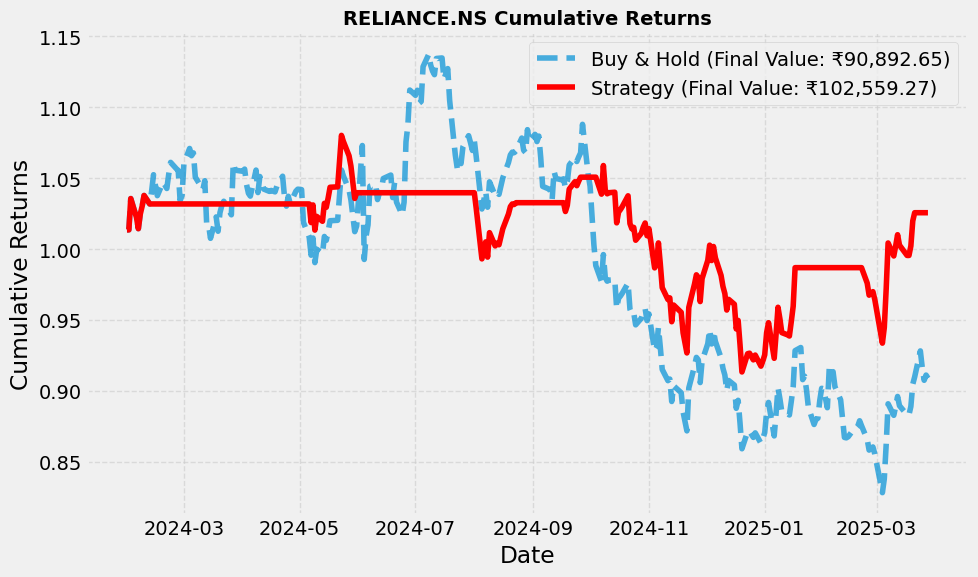

(                  close     upper_bb    middle_bb     lower_bb    kc_middle  \
 Date                                                                          
 2024-01-30  1402.863647  1427.608015  1339.519940  1251.431865  1348.632330   
 2024-01-31  1421.799438  1438.284976  1346.072699  1253.860422  1355.600626   
 2024-02-01  1421.824341  1447.690821  1352.092267  1256.493713  1361.907647   
 2024-02-02  1452.769287  1460.867209  1360.366681  1259.866153  1370.561136   
 2024-02-05  1434.157471  1467.929256  1367.377887  1266.826518  1376.617930   
 ...                 ...          ...          ...          ...          ...   
 2025-03-24  1302.099976  1301.709948  1229.257507  1156.805067  1244.530535   
 2025-03-25  1285.449951  1308.799052  1232.122504  1155.445956  1248.427622   
 2025-03-26  1273.050049  1313.347604  1235.047504  1156.747404  1250.772615   
 2025-03-27  1278.199951  1317.890576  1238.757501  1159.624427  1253.384743   
 2025-03-28  1275.099976  1321.406719  1

In [23]:
evaluate_strategy('RELIANCE.NS')


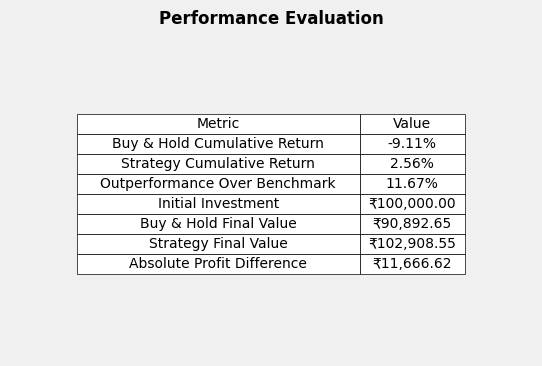

In [24]:
def display_performance_metrics(metrics):
    """
    Display performance metrics in a separate box.

    Parameters:
    metrics (dict): Dictionary containing performance metric labels and values.
    """
    fig, ax = plt.subplots(figsize=(6, 4))
    ax.axis("off")  # Hide axes

    # Convert metrics to DataFrame for structured display
    df_metrics = pd.DataFrame(metrics)

    # Create the table
    table = ax.table(
        cellText=df_metrics.values,
        colLabels=df_metrics.columns,
        cellLoc="center",
        loc="center",
    )

    # Styling the table
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.auto_set_column_width([0, 1])
    table.scale(1.2, 1.2)  # Adjust size

    plt.title("Performance Evaluation", fontsize=12, fontweight='bold')
    plt.show()

# Example usage
performance_metrics = {
    "Metric": [
        "Buy & Hold Cumulative Return",
        "Strategy Cumulative Return",
        "Outperformance Over Benchmark",
        "Initial Investment",
        "Buy & Hold Final Value",
        "Strategy Final Value",
        "Absolute Profit Difference"
    ],
    "Value": [
        "-9.11%",
        "2.56%",
        "11.67%",
        "₹100,000.00",
        "₹90,892.65",
        "₹102,908.55",
        "₹11,666.62"
    ]
}

display_performance_metrics(performance_metrics)

In [ ]:
chat